In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{ width:95%}</style>"))
import sys
print(sys.executable) 
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
from sklearn import preprocessing

from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
El codigo Python de este cuaderno está oculto para facilitar la lectura.
Para mostrar/ocultar el código, haz click <a href="javascript:code_toggle()">aquí.</a>.''')

## Load metrics

In [3]:
import pandas as pd
df_alg=pd.read_csv('output/metrics/merged_output_genetic.txt')
convert_dict = {'Dataset': "string", 
                'Algorithm': "string",
                'Population Length': "int64",
                'Generations': "int64",
                'Selection Scheme': "string",
                'Selection Candidates': "int64",
                'Crossover Scheme': "string",
                'Crossover Probability': "float64",
                'Mutation Scheme': "string",
                'Mutation Probability': "float64",
                'Replacement Scheme': "string",
                'Time(s)': "float64",
                'AvgValue': "float64",
                'BestAvgValue': "float64",
                'BestGeneration': "int64",
                'HV': "float64",
                'Spread': "float64",
                'NumSolutions': "float64",
                'Spacing': "float64",
                'NumGenerations': "int64"
               } 
df_alg = df_alg.astype(convert_dict) 
df_alg.loc[(df_alg.Dataset == 'dataset1'),'Dataset']='1'
df_alg.loc[(df_alg.Dataset == 'dataset2'),'Dataset']='2'

df_alg2=pd.read_csv('output/metrics/merged_output_grasp.txt',header=0)

convert_dict = {'Dataset': "string", 
                'Algorithm': "string",
                'Iterations': "float64",
                'Solutions per Iteration': "int64",
                'Initialization Type': "string",
                'Local Search Type': "string",
                'Path Relinking': "string",
                'Time(s)': "float64",
                'AvgValue': "float64",
                'BestAvgValue': "float64",
                'HV': "float64",
                'Spread': "float64",
                'NumSolutions': "int64",
                'Spacing': "float64",
                'NumGenerations': "int64"
               } 
df_alg2 = df_alg2.astype(convert_dict)
df_alg = df_alg.append(df_alg2)

## Pareto analysis
Change ```dataset``` value to load different dataset Paretos

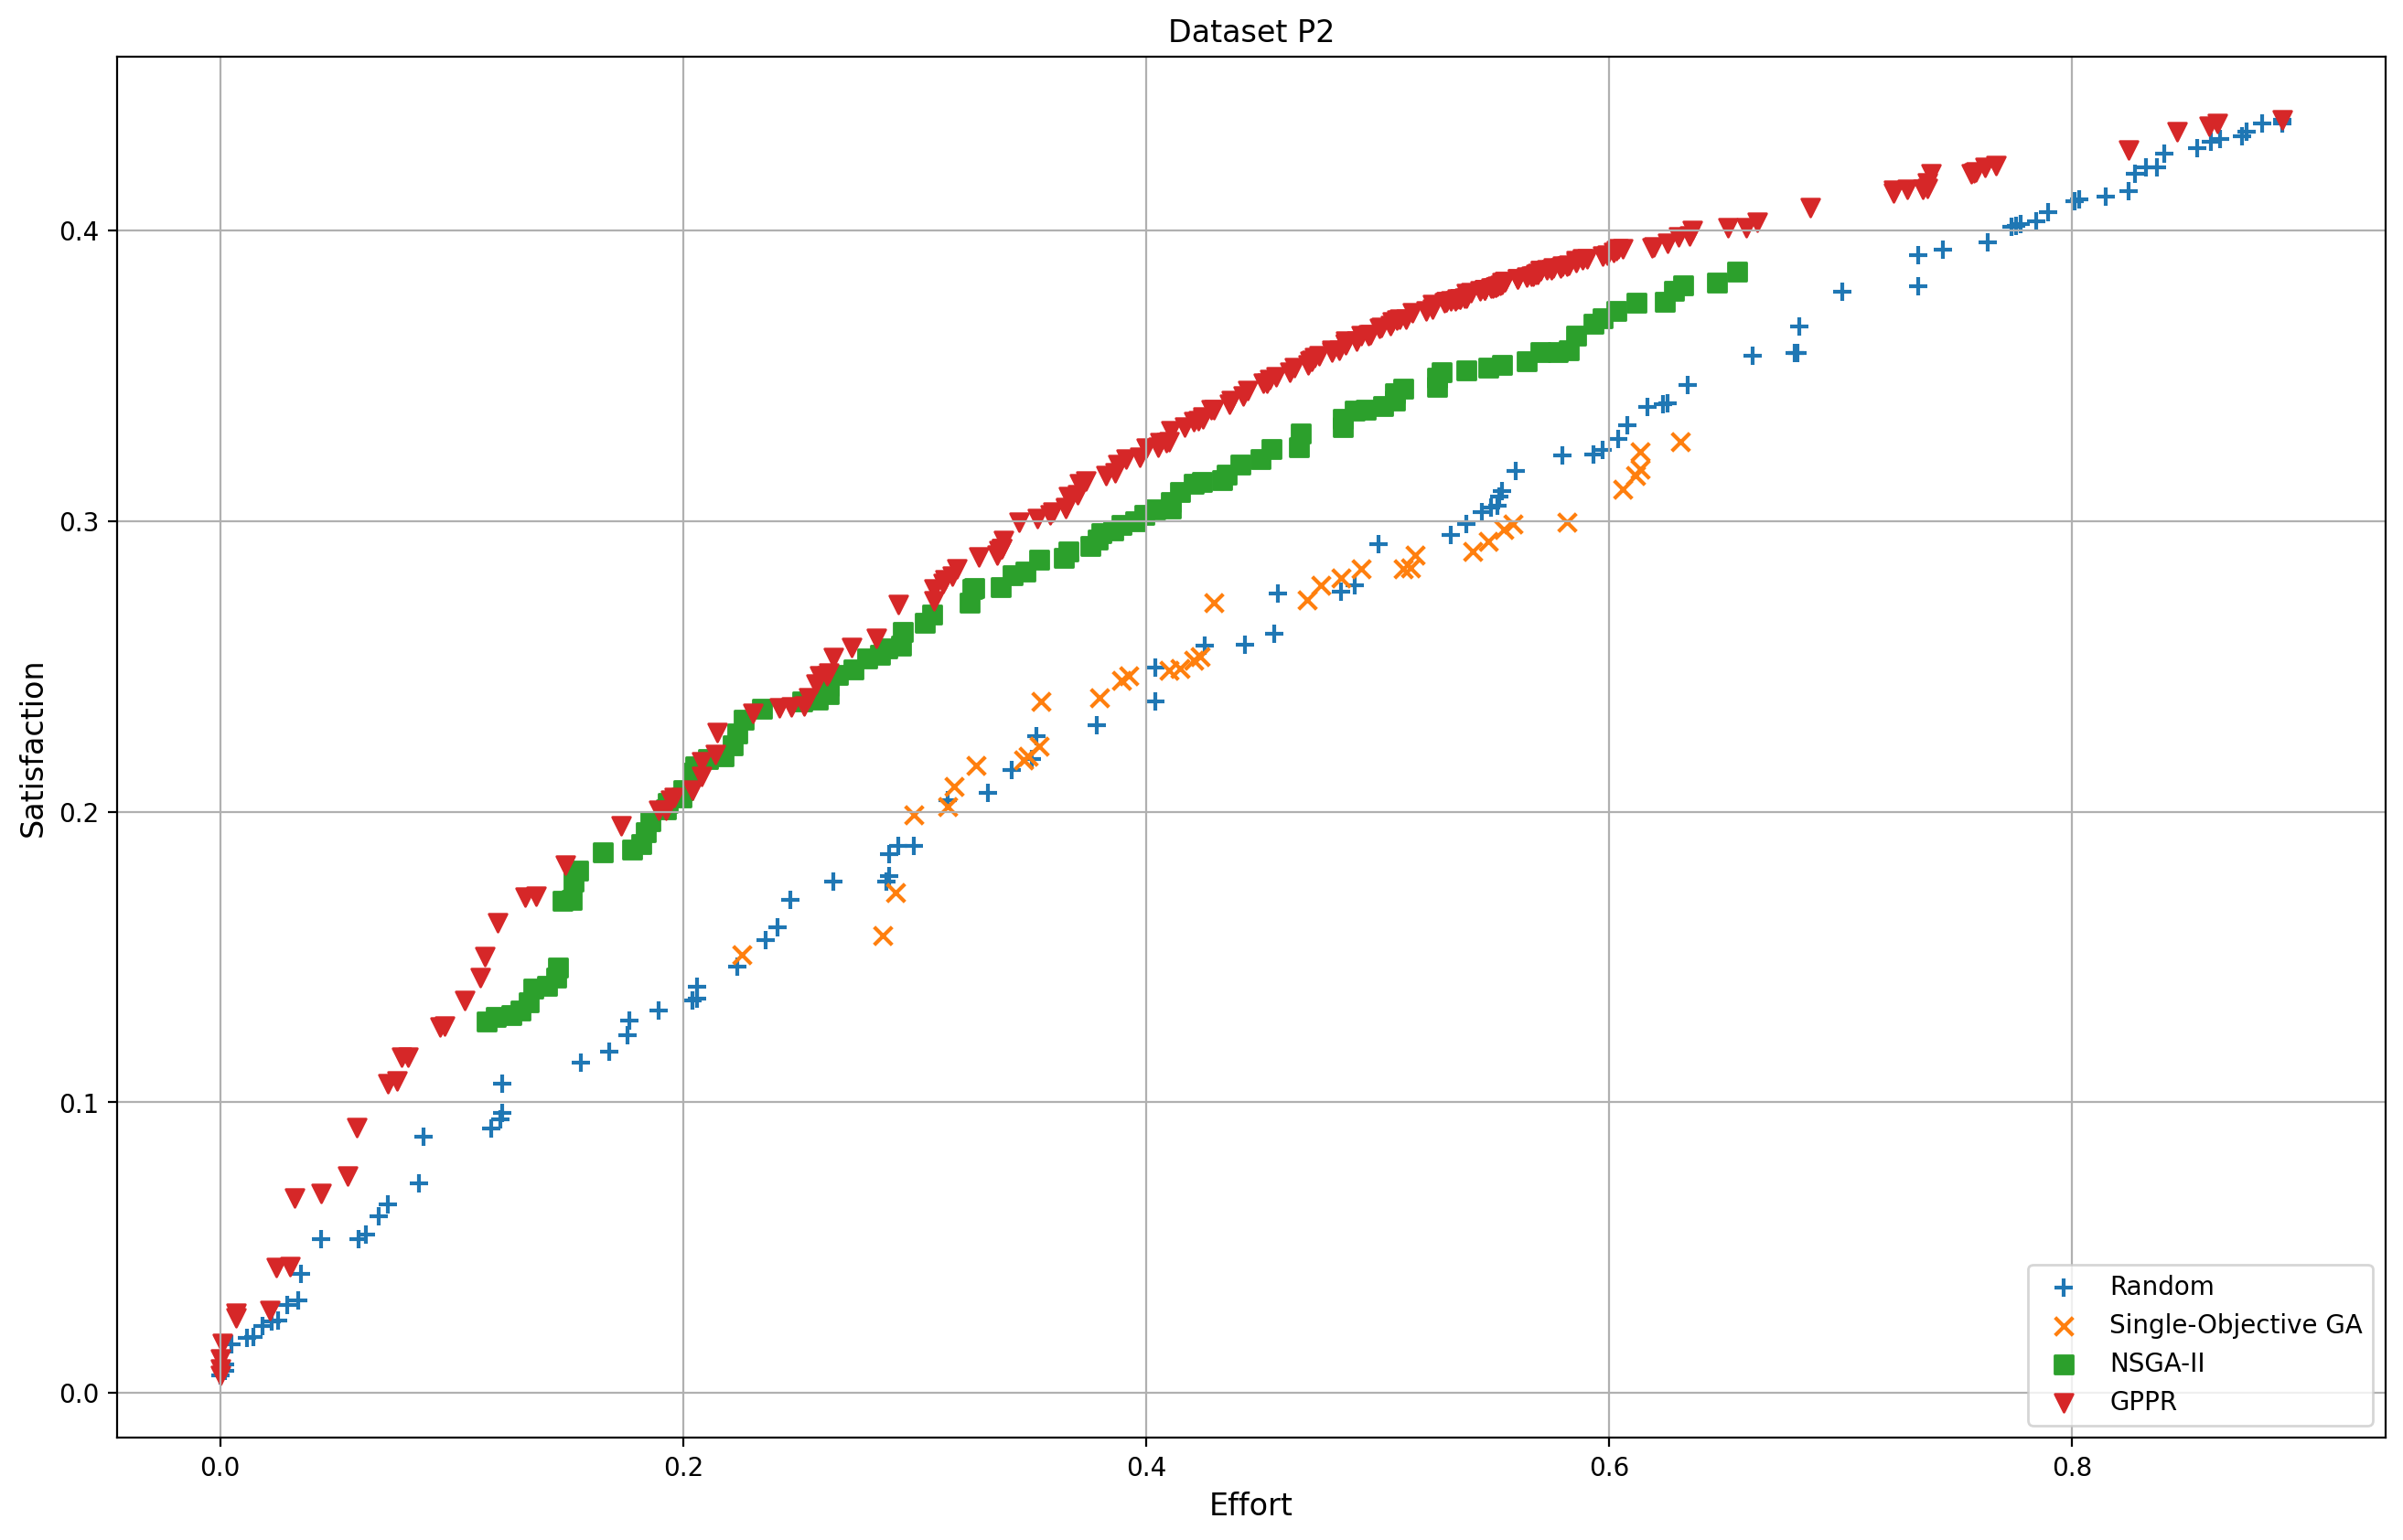

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from algorithms.GRASP.GRASP import GRASP
from algorithms.genetic.nsgaii.nsgaii_algorithm import NSGAIIAlgorithm
from algorithms.genetic.geneticnds.geneticnds_algorithm import GeneticNDSAlgorithm

sizes=[30,25,20,15,10,7,5]
markers=["+","x","s","v","h","o"]
labels=["Random","Single-Objective GA","NSGA-II","GPPR"]

datasets=["1","2","s1","s2","s3"]
dataset="2"
seed=10
generations=100
solutions_per_iteration=100
population_length=100
gens_genetic=100
algorithms = [
    GRASP(dataset=dataset,iterations=generations,solutions_per_iteration=solutions_per_iteration,seed=seed,
           init_type="uniform",local_search_type="None",
          path_relinking_mode="None"),
    GeneticNDSAlgorithm(dataset_name=dataset,random_seed=seed,population_length=100,max_generations=100,crossover_prob=0.8,
						   crossover="onepoint",mutation_prob=1.0,mutation="flip1bit",replacement="elitism"),
    NSGAIIAlgorithm(dataset_name=dataset,random_seed=seed,population_length=population_length,max_generations=gens_genetic
            ,crossover_prob=0.6,crossover="onepoint",mutation_prob=1.0,mutation="flip1bit",replacement="elitism"),
    GRASP(dataset=dataset,iterations=generations,solutions_per_iteration=solutions_per_iteration,seed=seed,
           init_type="stochastically",local_search_type="best_first_neighbor_random_domination",
          path_relinking_mode="after_local"),
]

for i in range(len(algorithms)):   
    if "GRASP" in algorithms[i].file:
        file = "output/paretos/pareto-grasp-"+algorithms[i].file
    else:
        file = "output/paretos/pareto-genetic-"+algorithms[i].file
    data = np.loadtxt(file,delimiter=',', dtype=float)
    x,y=data.T
    plt.scatter(x,y,label=labels[i],s=50,marker=markers[i])

plt.title(dataset)
plt.xlabel('Effort', fontsize=12)
plt.ylabel('Satisfaction', fontsize=12)
plt.legend(loc="lower right")
plt.title("Dataset "+dataset)
plt.grid(True)
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
plt.show()

## Metrics analysis

In [4]:
from scipy.stats import ranksums
import numpy as np
class AlgorithmDataGenetic():
    def __init__(self,a,rs,d,p,g,ss,sc,cs,cp,ms,mp):
        self.a=a
        self.rs=rs
        self.d=d
        self.p=p
        self.g=g
        self.ss=ss
        self.sc=sc
        self.cs=cs
        self.cp=cp
        self.ms=ms
        self.mp=mp
    
    def findConfigurationData(self,df):
        return df[(df["Population Length"]==self.p)&(df["Generations"]==self.g)
                     &(df["Selection Scheme"]==self.ss)&(df["Selection Candidates"]==self.sc)
                     &(df["Crossover Scheme"]==self.cs)&(df["Crossover Probability"]==self.cp)
                     &(df["Mutation Scheme"]==self.ms)&(df["Mutation Probability"]==self.mp)
              &(df["Algorithm"]==self.a)&(df["Replacement Scheme"]==self.rs)
              &(df["Dataset"]==self.d)
             ]
        
class AlgorithmDataGrasp():
    def __init__(self,a,d,it,so,ini,ls,pr):
        self.a=a
        self.it=it
        self.so=so
        self.ls=ls
        self.d=d
        self.ini=ini
        self.pr=pr
        
    def findConfigurationData(self,df):
        return df[(df["Iterations"]==self.it)&(df["Solutions per Iteration"]==self.so)
              &(df["Local Search Type"]==self.ls)&(df["Initialization Type"]==self.ini)
              &(df["Algorithm"]==self.a)&(df["Dataset"]==self.d)&(df["Path Relinking"]==self.pr)
             ]
    
dat="1"

datasets=["1","2","s1","s2","s3"]

cols=["HV","Spread","Spacing","NumSolutions","Time(s)"]
maxmin=[1,-1,1,1,-1]
for dat in datasets:
    print("------Dataset "+dat+"-----")
    algs = [
        AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitism',dat,100,100,"tournament",2,"onepoint",0.8,"flip1bit",1.0),
        AlgorithmDataGenetic("NSGAIIAlgorithm",'elitism',dat,100,100,"tournament",2,"onepoint",0.6,"flip1bit",1.0),
        AlgorithmDataGrasp("GRASP",dat,100,100,"stochastically","best_first_neighbor_random_domination","after_local"),
    ]
    for j in range(len(cols)): 
        print(cols[j])
        results=list()
        best_avg=0
        best_avgn=10**9
        best_alg_index=None
        for i in range(len(algs)):
            avg=np.mean((algs[i].findConfigurationData(df_alg)[cols])[cols[j]].values)
            results.append("{:.3f}".format(avg))
            if maxmin[j]>0 and avg>best_avg:
                best_avg=avg
                best_alg_index=i
            elif maxmin[j]<0 and avg<best_avgn:
                best_avgn=avg
                best_alg_index=i

        p_best=True
        p_list=[]
        for i in range(len(algs)):
            if i!=best_alg_index:
                dataA=(algs[best_alg_index].findConfigurationData(df_alg)[cols])[cols[j]].values
                dataB=(algs[i].findConfigurationData(df_alg)[cols])[cols[j]].values
                _, p = ranksums(dataA, dataB)
                print("p:",p)
                if p>=0.05:
                    p_best=False
                else:
                    p_list.append(i)

        if p_best:
            mark = '*'
        else:
            mark = ''
        for index in p_list:
            results[index]=results[index]+'-'
        results.insert(0,cols[j])
        print(results)


------Dataset 1-----
HV
p: 0.00015705228423075119
p: 0.00023856345402870988
['HV', '0.594-', '1.000', '0.909-']
Spread
p: 0.00015705228423075119
p: 0.12081938653567083
['Spread', '0.615', '0.963-', '0.648']
Spacing
p: 0.00015705228423075119
p: 0.0006051722625380393
['Spacing', '0.323-', '0.382', '0.371-']
NumSolutions
p: 0.00023856345402870988
p: 0.00023856345402870988
['NumSolutions', '26.400-', '56.000-', '64.333']
Time(s)
p: 0.00015705228423075119
p: 0.7439714780750569
['Time(s)', '17.967', '180.991-', '18.102']
------Dataset 2-----
HV
p: 0.00015705228423075119
p: 0.00015705228423075119
['HV', '0.157-', '0.407-', '0.973']
Spread
p: 0.00015705228423075119
p: 0.015564411386633814
['Spread', '0.637', '0.969-', '0.688-']
Spacing
p: 0.00015705228423075119
p: 0.00015705228423075119
['Spacing', '0.128-', '0.245-', '0.300']
NumSolutions
p: 0.00015705228423075119
p: 0.00015705228423075119
['NumSolutions', '35.600-', '99.600-', '314.000']
Time(s)
p: 0.00015705228423075119
p: 0.000157052284230